In [1]:
shape_cat=""
vol=""
z_range=""
key=""
quantile=""

In [2]:
# Parameters
shape_cat = "mcal"
vol = "vlim"
z_range = "high_z"
key = "lambda"
quantile = "1"


In [3]:
#This header file contains all the common packages
%matplotlib inline
%run /home/cz136/project/sa/lib/src/header.py $shape_cat $vol $z_range 
%run -i /home/cz136/project/sa/lib/src/func.py  

In [4]:
if quantile!="":
    i=int(quantile)

In [5]:
if key=="lambda":
    key=('All','All','LAMBDA_CHISQ')
elif key=="z":
    key=('All','All','Z_LAMBDA')

In [6]:
def thirds_by_key(catalog,key):
    step0=catalog[key].quantile(0.0)
    step1=catalog[key].quantile(0.333333)
    step2=catalog[key].quantile(0.666666)
    step3=catalog[key].quantile(1)
    
    catalog1=catalog[(catalog[key]>step0) & (catalog[key]<step1)]
    catalog2=catalog[(catalog[key]>step1) & (catalog[key]<step2)]
    catalog3=catalog[(catalog[key]>step2) & (catalog[key]<step3)]
    
    return (catalog1,catalog2,catalog3)

In [7]:
if key!="":
    clusters_list=thirds_by_key(clusters,key)
    clusters=clusters_list[i]

In [8]:
sep="------------------------------------------------------------------------------"
np.set_printoptions(precision=4)

In [9]:
NBINS=10

In [10]:
import treecorr
import astropy.cosmology
from fastprogress import master_bar, progress_bar
from ipywidgets import FloatProgress
from IPython.display import display
from tqdm import tqdm

In [11]:
if key=="":
    assert np.isin(shapes['All','MEM_MATCH_ID'].to_numpy(),clusters.index.to_numpy()).all()==True

In [12]:
def get_ng(cluster,mode1,mode2):
    if mode2=="abs":
        UPPER_BOUND=np.max(shapes[('All','R')])
        distance=('All','angR')
        
    elif mode2=="rel":
        UPPER_BOUND=1.2
        distance=('All','normLR')
    else:
        raise

    if mode1 == "s":
        def get_cluster_cen(cluster):
            return (get_unique_center_for_cluster(cluster))
        def get_cluster_sats(cluster):
            cen_mat_id=cluster.name
            cen_id=cluster[('Alt','Alt1','ID_CENT')]
            sats=shapes[shapes['All','MEM_MATCH_ID']==cen_mat_id]
            sats=sats[sats.index!=cen_id]
            return (sats)
    elif mode1=='r':
        def get_cluster_sats(cluster):
            return(shapes)
        def get_cluster_cen(cluster):
            return (random)

    else:
        raise


    cen=get_cluster_cen(cluster)
    sats=get_cluster_sats(cluster)


    sats_e1=sats[('All','e1')].to_numpy()
    sats_e2=sats[('All','e2')].to_numpy()
    sats_angr=sats[distance]

#     print(sats_e1,sats_e2)

    if type(cen[('All','RA')])==np.float64:
        cen_angr=np.array(cen[distance]).reshape(1)
        cen_ra=np.array(cen[('All','RA')]).reshape(1)
        cen_dec=np.array(cen[('All','DEC')]).reshape(1)
    else:
#         cen_e1=cen[('All','e1')].to_numpy
#         cen_e2=cen[('All','e2')].to_numpy()
        cen_angr=cen[distance].to_numpy()
        cen_ra=cen[('All','RA')].to_numpy()
        cen_dec=cen[('All','DEC')].to_numpy()




#     print(cen_e1,cen_e2)

    sats_ra=sats[('All','RA')].to_numpy()
    sats_dec=sats[('All','DEC')].to_numpy()




#     print(np.shape(cen_ra),np.shape(cen_dec))    
#     print(cen_ra,cen_dec)    

    sats_cat = treecorr.Catalog( g1 = sats_e1, g2   = sats_e2, 
                                 ra = sats_ra, dec = sats_dec,r=sats_angr,
                                 ra_units='deg', dec_units='deg')

    cen_cat = treecorr.Catalog( 
                                 ra = cen_ra, dec = cen_dec, r=cen_angr,
                                 ra_units='deg', dec_units='deg')

    ng = treecorr.NGCorrelation(nbins=NBINS, min_sep=0.01, max_sep=UPPER_BOUND, bin_slop=0.0,
                               metric="Rperp")
    ng.process_cross(cen_cat,sats_cat)

    return(ng)

In [13]:
def get_xi_meanlogr_varxi_npairs(cluster,mode1,mode2):
    ng=get_ng(cluster,mode1,mode2)
    return(np.array([ng.xi,ng.meanlogr,ng.varxi,ng.npairs]))

In [14]:
length=len(clusters)

def get_ng_list(mode2):
    ng_list=np.empty([length,4,NBINS])
    filler=np.zeros([1,4,NBINS])

    i=0
    e_count=0
    for index,cluster in tqdm(clusters.iterrows()):
        try:
            ng_list[i,:,:]=get_xi_meanlogr_varxi_npairs(cluster,'s',mode2)
            i=i+1
        except ValueError as e:
            ng_list[i,:,:]=filler
            i=i+1
            e_count=e_count+1
    print("Number of empty sat catalogs is {}".format(e_count))
    return (ng_list)

In [15]:
ng_abs=get_ng_list('abs')
ng_rel=get_ng_list('rel')

0it [00:00, ?it/s]

14it [00:00, 129.71it/s]

28it [00:00, 132.39it/s]

42it [00:00, 133.57it/s]

57it [00:00, 135.60it/s]

71it [00:00, 136.78it/s]

83it [00:00, 116.80it/s]

97it [00:00, 122.54it/s]

110it [00:00, 123.53it/s]

124it [00:00, 127.17it/s]

138it [00:01, 130.71it/s]

153it [00:01, 133.74it/s]

167it [00:01, 116.73it/s]

179it [00:01, 114.47it/s]

192it [00:01, 117.82it/s]

207it [00:01, 123.85it/s]

221it [00:01, 127.90it/s]

236it [00:01, 131.40it/s]

250it [00:01, 131.12it/s]

264it [00:02, 124.77it/s]

277it [00:02, 120.88it/s]

290it [00:02, 108.59it/s]

304it [00:02, 115.12it/s]

318it [00:02, 119.71it/s]

332it [00:02, 122.92it/s]

346it [00:02, 125.63it/s]

361it [00:02, 129.77it/s]

375it [00:03, 119.57it/s]

390it [00:03, 125.11it/s]

405it [00:03, 130.19it/s]

420it [00:03, 133.47it/s]

434it [00:03, 135.15it/s]

449it [00:03, 137.14it/s]

463it [00:03, 137.16it/s]

477it [00:03, 127.79it/s]

491it [00:03, 129.43it/s]

506it [00:03, 132.90it/s]

520it [00:04, 134.63it/s]

534it [00:04, 128.02it/s]

547it [00:04, 125.65it/s]

561it [00:04, 127.38it/s]

574it [00:04, 127.10it/s]

587it [00:04, 127.13it/s]

600it [00:04, 126.48it/s]

614it [00:04, 128.90it/s]

628it [00:04, 129.55it/s]

642it [00:05, 130.70it/s]

656it [00:05, 128.70it/s]

670it [00:05, 129.76it/s]

684it [00:05, 131.90it/s]

698it [00:05, 132.52it/s]

712it [00:05, 133.33it/s]

726it [00:05, 135.17it/s]

740it [00:05, 104.35it/s]

753it [00:05, 109.93it/s]

767it [00:06, 116.30it/s]

782it [00:06, 122.73it/s]

796it [00:06, 125.43it/s]

810it [00:06, 127.90it/s]

824it [00:06, 130.95it/s]

838it [00:06, 131.07it/s]

852it [00:06, 132.34it/s]

866it [00:06, 133.15it/s]

880it [00:06, 132.89it/s]

894it [00:07, 120.87it/s]

908it [00:07, 124.94it/s]

921it [00:07, 110.45it/s]

933it [00:07, 111.89it/s]

947it [00:07, 118.92it/s]

961it [00:07, 124.42it/s]

976it [00:07, 128.94it/s]

990it [00:07, 130.60it/s]

1004it [00:07, 132.18it/s]

1018it [00:08, 133.35it/s]

1032it [00:08, 134.70it/s]

1047it [00:08, 136.01it/s]

1061it [00:08, 137.12it/s]

1075it [00:08, 125.98it/s]

1089it [00:08, 129.24it/s]

1103it [00:08, 132.29it/s]

1118it [00:08, 134.58it/s]

1132it [00:08, 135.36it/s]

1147it [00:08, 136.46it/s]

1161it [00:09, 135.22it/s]

1175it [00:09, 134.71it/s]

1189it [00:09, 135.09it/s]

1204it [00:09, 137.40it/s]

1218it [00:09, 138.04it/s]

1232it [00:09, 137.77it/s]

1246it [00:09, 134.43it/s]

1253it [00:09, 128.17it/s]


0it [00:00, ?it/s]

13it [00:00, 117.39it/s]

Number of empty sat catalogs is 0


26it [00:00, 120.49it/s]

41it [00:00, 127.50it/s]

56it [00:00, 132.27it/s]

71it [00:00, 135.80it/s]

84it [00:00, 131.24it/s]

99it [00:00, 135.63it/s]

114it [00:00, 138.23it/s]

129it [00:00, 140.40it/s]

144it [00:01, 141.11it/s]

159it [00:01, 142.43it/s]

175it [00:01, 144.74it/s]

190it [00:01, 146.24it/s]

205it [00:01, 147.12it/s]

220it [00:01, 147.81it/s]

235it [00:01, 148.28it/s]

250it [00:01, 147.28it/s]

266it [00:01, 148.61it/s]

281it [00:01, 149.03it/s]

296it [00:02, 147.06it/s]

311it [00:02, 146.24it/s]

326it [00:02, 132.03it/s]

340it [00:02, 131.14it/s]

355it [00:02, 134.14it/s]

370it [00:02, 138.20it/s]

385it [00:02, 139.41it/s]

400it [00:02, 141.23it/s]

415it [00:02, 143.18it/s]

430it [00:03, 143.42it/s]

445it [00:03, 141.52it/s]

460it [00:03, 143.22it/s]

475it [00:03, 143.86it/s]

490it [00:03, 143.79it/s]

505it [00:03, 144.11it/s]

520it [00:03, 143.64it/s]

535it [00:03, 135.98it/s]

550it [00:03, 138.14it/s]

565it [00:03, 139.80it/s]

580it [00:04, 114.20it/s]

594it [00:04, 116.97it/s]

609it [00:04, 124.41it/s]

624it [00:04, 130.62it/s]

639it [00:04, 135.21it/s]

654it [00:04, 139.04it/s]

669it [00:04, 141.79it/s]

685it [00:04, 144.13it/s]

701it [00:05, 146.12it/s]

716it [00:05, 145.82it/s]

731it [00:05, 146.92it/s]

746it [00:05, 147.20it/s]

761it [00:05, 147.65it/s]

776it [00:05, 147.04it/s]

791it [00:05, 146.10it/s]

806it [00:05, 145.88it/s]

821it [00:05, 121.61it/s]

835it [00:06, 125.45it/s]

849it [00:06, 127.85it/s]

863it [00:06, 102.89it/s]

875it [00:06, 101.60it/s]

889it [00:06, 109.22it/s]

902it [00:06, 113.97it/s]

916it [00:06, 118.87it/s]

929it [00:06, 109.60it/s]

943it [00:06, 116.61it/s]

956it [00:07, 99.73it/s] 

968it [00:07, 101.99it/s]

979it [00:07, 95.12it/s] 

991it [00:07, 98.63it/s]

1005it [00:07, 108.04it/s]

1020it [00:07, 117.02it/s]

1035it [00:07, 124.67it/s]

1050it [00:07, 130.65it/s]

1065it [00:08, 135.27it/s]

1080it [00:08, 138.11it/s]

1095it [00:08, 139.25it/s]

1110it [00:08, 135.11it/s]

1124it [00:08, 133.56it/s]

1138it [00:08, 132.26it/s]

1152it [00:08, 132.56it/s]

1166it [00:08, 133.71it/s]

1180it [00:08, 121.41it/s]

1195it [00:09, 127.51it/s]

1209it [00:09, 123.52it/s]

1223it [00:09, 126.35it/s]

1236it [00:09, 126.59it/s]

1249it [00:09, 122.76it/s]

1253it [00:09, 131.82it/s]

Number of empty sat catalogs is 0


In [16]:
try:
    ng_r=get_xi_meanlogr_varxi_npairs(clusters,'r','abs')
except ValueError as e:
    print(e)
    ng_r=np.array([[1],[1],[1],[1]])

In [17]:
# ng_list=np.load("/home/cz136/project/sa/data/{}/ng_list_cross.npy".format(dir_string))
# ng_r=np.load("/home/cz136/project/sa/data/{}/ng_r_list_cross.npy".format(dir_string))

In [18]:
def get_sum(ng_list):
    sum_xi_cross=np.sum(ng_list[:,0,:],axis=0)
    sum_meanlogr=np.sum(ng_list[:,1,:],axis=0)
    sum_npairs=np.sum(ng_list[:,3,:],axis=0)
    return(sum_xi_cross,sum_meanlogr,sum_npairs)

def get_mean(ng_list):
    sum_xi_cross=np.sum(ng_list[:,0,:],axis=0)
    sum_meanlogr=np.sum(ng_list[:,1,:],axis=0)
    sum_npairs=np.sum(ng_list[:,3,:],axis=0)
    return(sum_xi_cross/sum_npairs,sum_meanlogr/sum_npairs)

In [19]:
def get_sigma(ng_list):
    xi_array=ng_list[:,0,:]
    npairs_array=ng_list[:,3,:]
    
    N=len(xi_array)
    
    jk_xi_array=np.empty([N,NBINS])
    
    def get_xi(drop_1_xi,drop_1_npairs):
        return(np.sum(drop_1_xi,axis=0)/np.sum(drop_1_npairs,axis=0))
    
    for i in range(N):
        drop_1_xi=np.delete(xi_array,i,axis=0)
        drop_1_npairs=np.delete(npairs_array,i,axis=0)
        jk_xi_array[i,:]=get_xi(drop_1_xi,drop_1_npairs)
        
    return(np.sqrt(N)*np.std(jk_xi_array,axis=0))

In [20]:
sum_abs=get_sum(ng_abs)
mean_abs=get_mean(ng_abs)
sig_abs=get_sigma(ng_abs)

sum_rel=get_sum(ng_rel)
mean_rel=get_mean(ng_rel)
sig_rel=get_sigma(ng_rel)

In [21]:
r_xi=ng_r[0]/ng_r[3]
r_meanlogr=ng_r[1]/ng_r[3]
r_sigma=r_xi/np.sqrt(len(clusters))

In [22]:
if key!="":
    np.savez("/home/cz136/project/sa/data/2pt/{}_{}_{}_{}.npz".format(shape_cat,vol,key,quantile),sum_abs=sum_abs,mean_abs=mean_abs,sig_abs=sig_abs,sum_rel=sum_rel,mean_rel=mean_rel,sig_rel=sig_rel,r_xi=r_xi,r_meanlogr=r_meanlogr,r_sigma=r_sigma)

In [23]:
def plt_w_error(meanlogr,xi,varxi,title):
    fig,ax=plt.subplots()
    ax.errorbar(np.exp(meanlogr),xi,yerr=varxi)
    ax.set_title(title)
    ax.set_xscale('log')
#     ax.set_ylim(-0.020,0.020)
    plt.show()
    
    if title==r"$\gamma_+$ of Clusters, Normalized by R_LAMBDA":
        plt.savefig("/home/cz136/project/sa/image/rel_{}_{}_{}.png".format(shape_cat,vol,z_range))
#     plt.xscale('log')
#     plt.yscale('log')

# Statistics

In [24]:
def print_data(sum_,mean_):
    sum_string=["Aggregated xi:", "Aggregated meanlogr:","Aggregated npairs:"]
    for i,data in enumerate(sum_):
        print(sum_string[i])
        print(sum_[i])
        print(sep)
    mean_string=["Mean xi:", "Mean meanlogr:","Mean npairs:"]
    for i,data in enumerate(mean_):
        print(mean_string[i])
        print(mean_[i])
        print(sep)

# Abs Plots

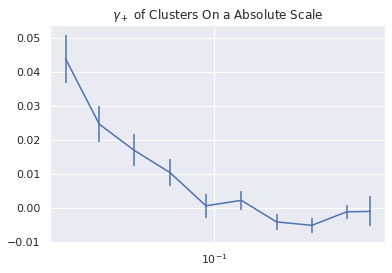

Aggregated xi:
[ -9.4081 -11.6379 -12.6201 -12.0588  -1.183   -6.7446  18.1605  29.6194
   6.6896   1.1895]
------------------------------------------------------------------------------
Aggregated meanlogr:
[ -922.5603 -1816.3907 -2506.5575 -3357.8917 -4451.6868 -5827.8412
 -6478.9722 -5727.732  -3037.7504  -242.483 ]
------------------------------------------------------------------------------
Aggregated npairs:
[ 214.  471.  739. 1157. 1841. 3005. 4420. 5790. 5821. 1172.]
------------------------------------------------------------------------------
Mean xi:
[-0.044  -0.0247 -0.0171 -0.0104 -0.0006 -0.0022  0.0041  0.0051  0.0011
  0.001 ]
------------------------------------------------------------------------------
Mean meanlogr:
[-4.311  -3.8565 -3.3918 -2.9022 -2.4181 -1.9394 -1.4658 -0.9892 -0.5219
 -0.2069]
------------------------------------------------------------------------------


In [25]:
plt_w_error(mean_abs[1],-mean_abs[0],sig_abs,r"$\gamma_+$ of Clusters On a Absolute Scale ")
print_data(sum_abs,mean_abs)

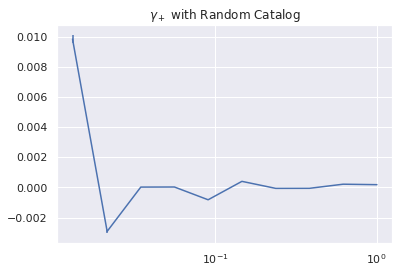

[ 9.8275e-03 -2.9159e-03  1.9740e-05  2.5301e-05 -8.2103e-04  3.9983e-04
 -6.5348e-05 -6.1656e-05  2.1127e-04  1.8010e-04]
[-2.7763e-04  8.2374e-05 -5.5765e-07 -7.1477e-07  2.3195e-05 -1.1295e-05
  1.8461e-06  1.7418e-06 -5.9685e-06 -5.0879e-06]


In [26]:
plt_w_error(r_meanlogr,-r_xi,r_sigma,r"$\gamma_+$ with Random Catalog")
print(-r_xi)
print(r_sigma)

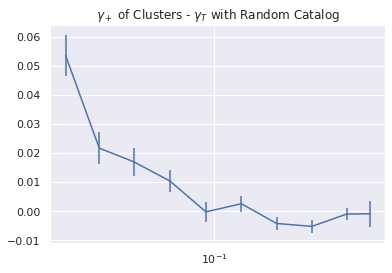

In [27]:
plt_w_error(mean_abs[1],-(mean_abs[0]+r_xi),np.hypot(r_sigma,sig_abs),r"$\gamma_+$ of Clusters - $\gamma_T$ with Random Catalog")

# Rel plots

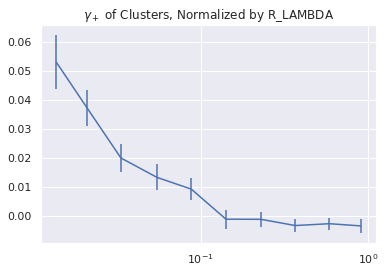

Aggregated xi:
[ -5.3139 -11.5565 -12.2498 -11.9255 -12.7039   2.419    3.9108  16.1956
  15.6196  15.2637]
------------------------------------------------------------------------------
Aggregated meanlogr:
[ -428.375  -1196.3492 -2072.0059 -2583.6876 -3313.6336 -4483.1416
 -5286.2854 -5001.0561 -3202.0311  -470.9912]
------------------------------------------------------------------------------
Aggregated npairs:
[ 100.  310.  610.  890. 1364. 2295. 3584. 4989. 5987. 4535.]
------------------------------------------------------------------------------
Mean xi:
[-0.0531 -0.0373 -0.0201 -0.0134 -0.0093  0.0011  0.0011  0.0032  0.0026
  0.0034]
------------------------------------------------------------------------------
Mean meanlogr:
[-4.2837 -3.8592 -3.3967 -2.903  -2.4294 -1.9534 -1.475  -1.0024 -0.5348
 -0.1039]
------------------------------------------------------------------------------


<Figure size 432x288 with 0 Axes>

In [28]:
plt_w_error(mean_rel[1],-mean_rel[0],sig_rel,r"$\gamma_+$ of Clusters, Normalized by R_LAMBDA")
print_data(sum_rel,mean_rel)